# Import Modules

In [34]:
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors
import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import ttest_ind
from typing import List
import math
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import phate
import sklearn.utils

# Connect to Database

In [2]:
# connect to database
DB_PARAM_FILEPATH = os.path.join('C'+os.getcwd()[1:], '..', 'db_connection_params.csv')
db_params = pd.read_csv(DB_PARAM_FILEPATH)
db_host = db_params.host.iloc[0]
db_user = db_params.username.iloc[0]
db_pass = db_params.password.iloc[0]
db_name = db_params.database.iloc[0]
db_table = db_params.table.iloc[0]

print('Connecting to database...')
cnx = mysql.connector.connect(user = db_user, password = db_pass, host = db_host, database = db_name)
cursor = cnx.cursor(buffered=True)
print('Done connecting to database.')

Connecting to database...
Done connecting to database.


# Read Articles From Database

In [3]:
# read articles into dataframe
print('reading "articles" table')
query = 'SELECT * FROM articles WHERE pub_date IS NOT NULL AND source IS NOT NULL AND article_title IS NOT NULL'
# mysql package technically isn't supported, but this works fine
articles = pd.read_sql(query, cnx)
print('done reading "articles" table')
articles

reading "articles" table
done reading "articles" table


C:\Users\eeday\AppData\Local\Temp\ipykernel_8384\1549451138.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  articles = pd.read_sql(query, cnx)


,pmc_id,archive_href,abstract_text,pub_date,source,article_title
0,PMC7284390,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,the csp cell surface protein microsatellite ma...,2020-05-08,Microorganisms,Identification of CSP Types and Genotypic Vari...
1,PMC10478028,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,abstractseveral environmental chemicals are su...,2022-11-18,Cereb Cortex Commun,Fetal blockade of nicotinic acetylcholine tran...
2,PMC6494343,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,abstractchronic pulmonary aspergillosis cpa is...,2019-04-19,Medicine (Baltimore),"Evaluation of Aspergillus IgG, IgM antibody fo..."
3,PMC8501721,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,backgroundautism spectrum disorder asd is a co...,2021-10-09,BMC Neurosci,A systematic review of common genetic variatio...
4,PMC9620685,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,background and aimstrategies to modify and adj...,2022-09-21,Autism Dev Lang Impair,Strategies in supporting inclusive education f...
...,...,...,...,...,...,...
903,PMC5964587,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,background no largescale study of the timing o...,2018-05-07,Int J Pediatr,The Age at Diagnosis of Autism Spectrum Disord...
904,PMC10046036,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,βfructofuranosidases ffases are enzymes involv...,2023-03-03,BioTech (Basel),"Production, Kinetic/Thermodynamic Study, and E..."
905,PMC7528686,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,the βclass of carbonic anhydrases βcas are zin...,2020-09-18,Mol Cells,Crystal Structure of β-Carbonic Anhydrase CafA...
906,PMC5648821,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,autism spectrum disorders asd are characterise...,2017-10-19,Sci Rep,An integrated EEG and eye-tracking approach fo...


# Filter Articles
Need a set of articles without Aspergillus in title.

In [4]:
# filter out any articles with "Aspergillus" in title
filtered_articles = articles[~articles["article_title"].str.contains('spergillus')]
# get a set of all articles with "Aspergillus" in title
asg_articles = articles[~articles['article_title'].str.contains('spergillus')]
filtered_articles

,pmc_id,archive_href,abstract_text,pub_date,source,article_title
1,PMC10478028,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,abstractseveral environmental chemicals are su...,2022-11-18,Cereb Cortex Commun,Fetal blockade of nicotinic acetylcholine tran...
3,PMC8501721,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,backgroundautism spectrum disorder asd is a co...,2021-10-09,BMC Neurosci,A systematic review of common genetic variatio...
4,PMC9620685,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,background and aimstrategies to modify and adj...,2022-09-21,Autism Dev Lang Impair,Strategies in supporting inclusive education f...
5,PMC8162135,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,this exploratory study aimed to explore the as...,2020-08-08,Autism,"Timing of diagnosis, depression and self-harm ..."
7,PMC6749978,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,there is face validity to the expectation that...,2019-09-12,Cogn Behav Neurol,Psychoeducational Interventions for Adults Wit...
...,...,...,...,...,...,...
901,PMC9344572,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,low breastfeeding rates are driven by multiple...,2022-04-12,Autism,Autistic women’s views and experiences of infa...
902,PMC6545013,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,williams beuren syndrome wbs is a multiple mal...,2019-05-31,Orphanet J Rare Dis,"Molecular investigation, using chromosomal mic..."
903,PMC5964587,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,background no largescale study of the timing o...,2018-05-07,Int J Pediatr,The Age at Diagnosis of Autism Spectrum Disord...
906,PMC5648821,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/...,autism spectrum disorders asd are characterise...,2017-10-19,Sci Rep,An integrated EEG and eye-tracking approach fo...


# Extract Corpus
We need to extract all abstracts to create a corpus.

In [5]:
# extract corpus
abstracts = list(articles.abstract_text)
filtered_abstracts = list(filtered_articles.abstract_text)
asg_abstracts = list(asg_articles.abstract_text)

# Convert to Word Embeddings
We'll be using the Google News pre-trained word embeddings model.

In [6]:
WORD_EMBEDDINGS_FILEPATH = os.path.join('..', 'word_embeddings', 'GoogleNews-vectors-negative300.bin')
gn_vectors = KeyedVectors.load_word2vec_format(WORD_EMBEDDINGS_FILEPATH, binary=True)

Let's define a function which averages word embedding vectors across a text.

In [7]:
def get_text_avg(word_vectors: KeyedVectors, text: str) -> np.array:
    # get list of words in text
    wl = [i.strip() for i in text.split()]
    
    # initial word vector list
    wvl = []

    for word in wl:
        try:
            wvl.append(word_vectors[word])
        except KeyError:
            # word not present, continue
            continue
    
    return np.mean(np.array(wvl), axis=0)

And test it out on a few articles.

In [8]:
a0 = abstracts[0]
a1 = abstracts[1]
a2 = abstracts[2]
# a0 and a2 should be most similar
print(a0)
print(a1)
print(a2)
print()

we_a0 = get_text_avg(gn_vectors, a0)
we_a1 = get_text_avg(gn_vectors, a1)
we_a2 = get_text_avg(gn_vectors, a2)

print('a0 x a1: {0}'.format(cosine_similarity([we_a0], [we_a1])))
print('a0 x a2: {0}'.format(cosine_similarity([we_a0], [we_a2])))
print('a1 x a2: {0}'.format(cosine_similarity([we_a1], [we_a2])))

the csp cell surface protein microsatellite marker is useful for typing aspergillus fumigatus isolates and determining relationships at the subpopulation level because it has shown high discriminatory power in the present study 90 a fumigatus isolates from mexico mx argentina ar france fr and peru pe were identified through a phylogenetic analysis using the bena gene fragment and were typed with the csp microsatellite and the types were identified using the nomenclature recommended in the literature genetic variability was analyzed through haplotype diversity nucleotide diversity polymorphic sites and nucleotide differences between pairs of sequences the population structure was evaluated using the tajima’s d statistic no new csp types were recorded in the mx fr and pe isolates while in the ar isolates two new csp types were identified t25 and t26 the most common csp types in the studied populations were t01 t02 t03 and t04a these results are consistent with findings in other countries

## Simple Average Word Embeddings Test
We need to validate our word embeddings as a metric for text similarity. To do so, we will take advantage of the included articles on Aspergillus and perform a simple t-test.

In [9]:
non_asg_we = [get_text_avg(gn_vectors, i) for i in filtered_abstracts]
asg_we = [get_text_avg(gn_vectors, i) for i in asg_abstracts]

In [10]:
# within-group cosine similarity
wig_cs = []

for i in range(len(non_asg_we)-1):
    for j in range(i, len(non_asg_we)):
        wig_cs.append(cosine_similarity([non_asg_we[i]], [non_asg_we[j]]))

for i in range(len(asg_we)-1):
    for j in range(i, len(asg_we)):
        wig_cs.append(cosine_similarity([asg_we[i]], [asg_we[j]]))

len(wig_cs)

494910

In [11]:
# between-group cosine similarity
bg_cs = []

for i in range(len(non_asg_we)):
    for j in range(len(asg_we)):
        bg_cs.append(cosine_similarity([non_asg_we[i]], [asg_we[j]]))

len(bg_cs)

494209

In [12]:
ttest_ind(wig_cs, bg_cs)

TtestResult(statistic=array([[1.41599934]]), pvalue=array([[0.15677601]]), df=array([[989117.]]))

Since there is not a significant difference between groups based on this t-test, we may need a more robust metric for text differences.
For simplicity, let us define each text embedding as a weighted average of the word embeddings in the i<sub>th</sub> text containing $N$ unique words = $\vec{d_i} = \frac{1}{N} \sum_{j=1}^{N} \tau_{i,j} \vec{\nu_j}$ where $\vec{\nu_j}$ is the embedding of the j<sub>th</sub> unique word in the document and $\tau_{i,j}$ is the TF-IDF value for the j<sub>th</sub> unique word of the i<sub>th</sub> document. We will call this metric "TIWE" (Term-Frequency Inverse-Document-Frequency Weighted Embeddings).

The hope is that this will increase the relative importance of words that are not common between documents, allowing for easier differentiation. The theoretical justification for this is loosely derived from a conference paper by Sanjeev et al. (2017) titled "A simple but tough-to-beat baseline for sentence embeddings".

It is worth noting that the ideal method would use a metric similar to TF-IDF but based on word embeddings rather than words.

In [52]:
def get_document_frequency(term: str, corpus: List[List[str]]) -> int:
    return sum([text.count(term) > 0 for text in corpus])

def get_tiwe_values(corpus: List[List[str]], word_vectors: KeyedVectors) -> List[np.array]:
    all_tiwes = []

    # create a document-frequency hash table
    df_ht = {}

    for i in range(len(corpus)):
        doc_tiwes = []
        document = corpus[i]
        words = list(set(document))
        N = len(words)
        for j in range(N):
            # if word not in document-frequency hash table, add
            word = words[j]
            if word not in df_ht:
                df_ht[word] = get_document_frequency(word, corpus)

            # calculate TF-IDF
            tf_idf = document.count(words[j]) * math.log(N / df_ht[word])

            # get word embedding
            try:
                doc_tiwes.append(word_vectors[word] * tf_idf)
            except KeyError:
                # word not present, continue
                continue
        # average across doc tiwes
        all_tiwes.append(np.mean(np.array(doc_tiwes), axis=0))

    return all_tiwes

## TIWE Test

In [57]:
non_asg_tiwe = get_tiwe_values(filtered_abstracts, gn_vectors)
asg_tiwe = get_tiwe_values(asg_abstracts, gn_vectors)

In [58]:
# within-group cosine similarity
wig_cs_tiwe = []

for i in range(len(non_asg_tiwe)-1):
    for j in range(i, len(non_asg_tiwe)):
        wig_cs_tiwe.append(cosine_similarity([non_asg_tiwe[i]], [non_asg_tiwe[j]]))

for i in range(len(asg_tiwe)-1):
    for j in range(i, len(asg_tiwe)):
        wig_cs_tiwe.append(cosine_similarity([asg_tiwe[i]], [asg_tiwe[j]]))

len(wig_cs_tiwe)

494910

In [59]:
# between-group cosine similarity
bg_cs_tiwe = []

for i in range(len(non_asg_tiwe)):
    for j in range(len(asg_tiwe)):
        bg_cs_tiwe.append(cosine_similarity([non_asg_tiwe[i]], [asg_tiwe[j]]))

len(bg_cs_tiwe)

494209

In [60]:
ttest_ind(wig_cs_tiwe, bg_cs_tiwe)

TtestResult(statistic=array([[0.47286385]]), pvalue=array([[0.63631042]]), df=array([[989117.]]))

OK, um, yeah, nope. Why do I do this to myself?

Well, I guess let's just try clustering with the non-TIWE metric...

# Perform K-Means Clustering

To make this easier, we'll be using some code from https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/.

In [35]:
def mbkmeans_clusters(
	X,
    k: int,
    mb: int,
    print_silhouette_values: bool, 
    seed: int = 42
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb, random_state=seed).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_, silhouette_score(X, km.labels_)

Let's get our word embeddings for all documents:

In [26]:
all_we = [get_text_avg(gn_vectors, i) for i in abstracts]

In [82]:
# select a cluster number
max_k = 20

sil_scores_df = pd.DataFrame({
    'k': [i for i in range(2, max_k+1)],
    'silhouette_score_mean': [math.inf for i in range(2, max_k+1)],
    'silhouette_score_var': [math.inf for i in range(2, max_k+1)],
    'silhouette_score_se':  [math.inf for i in range(2, max_k+1)],
    'wcss_mean': [math.inf for i in range(2, max_k+1)],
    'wcss_var': [math.inf for i in range(2, max_k+1)],
    'wcss_se':  [math.inf for i in range(2, max_k+1)]
})

n_tests = 40

for k in range(2, max_k+1):
    # need to get an average of silhouette scores with varying random seed
    print(f'K: {k}')
    sil_scores_list = []
    wcss_list = []
    for seed in range(2, 2+n_tests+1):
        clustering, cluster_labels, sil_score = mbkmeans_clusters(X=all_we,
                                                    k=k,
                                                    mb = 500,
                                                    print_silhouette_values=False,
                                                    seed=seed)
        sil_scores_list.append(sil_score)
        wcss_list.append(clustering.inertia_)

    sil_score_mean = np.mean(sil_scores_list)
    sil_score_var = np.var(sil_scores_list)
    sil_score_se = np.std(sil_scores_list)/math.sqrt(n_tests)

    sil_scores_df.loc[sil_scores_df['k'] == k, 'silhouette_score_mean'] = sil_score_mean
    sil_scores_df.loc[sil_scores_df['k'] == k, 'silhouette_score_var'] = sil_score_var
    sil_scores_df.loc[sil_scores_df['k'] == k, 'silhouette_score_se'] = sil_score_se

    wcss_mean = np.mean(wcss_list)
    wcss_var = np.var(wcss_list)
    wcss_se = np.std(wcss_list)/math.sqrt(n_tests)

    sil_scores_df.loc[sil_scores_df['k'] == k, 'wcss_mean'] = wcss_mean
    sil_scores_df.loc[sil_scores_df['k'] == k, 'wcss_var'] = wcss_var
    sil_scores_df.loc[sil_scores_df['k'] == k, 'wcss_se'] = wcss_se

    print()

K: 2
For n_clusters = 2
Silhouette coefficient: 0.16
Inertia:164.39191395241414
For n_clusters = 2
Silhouette coefficient: 0.10
Inertia:189.79650027122747
For n_clusters = 2
Silhouette coefficient: 0.16
Inertia:164.3699365523335
For n_clusters = 2
Silhouette coefficient: 0.16
Inertia:164.8398569371118
For n_clusters = 2
Silhouette coefficient: 0.15
Inertia:164.81616856390542
For n_clusters = 2
Silhouette coefficient: 0.12
Inertia:170.6808789495812
For n_clusters = 2
Silhouette coefficient: 0.16
Inertia:164.41814350214537
For n_clusters = 2
Silhouette coefficient: 0.15
Inertia:164.40631501816847
For n_clusters = 2
Silhouette coefficient: 0.16
Inertia:164.27611943039688
For n_clusters = 2
Silhouette coefficient: 0.15
Inertia:164.5722152311025
For n_clusters = 2
Silhouette coefficient: 0.16
Inertia:164.35296762597562
For n_clusters = 2
Silhouette coefficient: 0.16
Inertia:164.73079138961015
For n_clusters = 2
Silhouette coefficient: 0.16
Inertia:164.4835566120538
For n_clusters = 2
Silhou

In [83]:
sil_scores_df

,k,silhouette_score_mean,silhouette_score_var,silhouette_score_se,wcss_mean,wcss_var,wcss_se
0,2,0.159917,0.001296,0.005692,166.243450,32.619533,0.903044
1,3,0.108053,0.002180,0.007382,159.076761,28.401201,0.842633
2,4,0.091674,0.001992,0.007058,151.814816,32.677439,0.903845
3,5,0.081272,0.000950,0.004874,142.184220,78.691446,1.402600
4,6,0.065152,0.000608,0.003899,136.338751,105.605024,1.624846
5,7,0.059165,0.000702,0.004191,131.099935,148.450367,1.926463
6,8,0.063124,0.000164,0.002026,124.879543,108.387978,1.646116
7,9,0.059047,0.000189,0.002176,119.960134,97.055172,1.557684
8,10,0.056885,0.000143,0.001887,117.252012,93.030854,1.525048
9,11,0.055289,0.000064,0.001262,113.904926,85.668769,1.463461


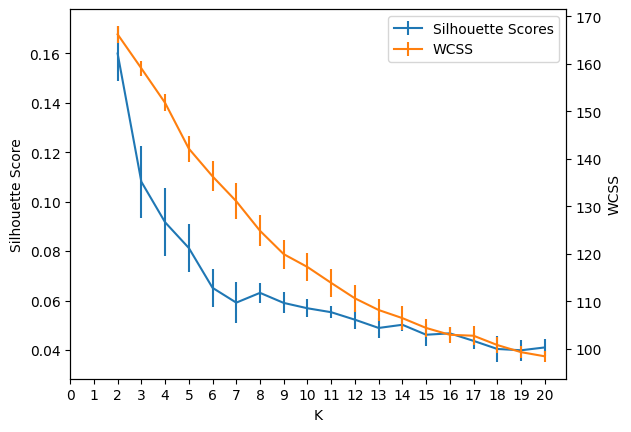

In [95]:
fix, ax = plt.subplots()

twin1 = ax.twinx()

p1 = ax.errorbar(sil_scores_df.k,
             sil_scores_df.silhouette_score_mean,
             yerr=1.96*sil_scores_df.silhouette_score_se,
             label = 'Silhouette Scores',
             color='C0')
p2 = twin1.errorbar(sil_scores_df.k,
             sil_scores_df.wcss_mean,
             yerr=1.96*sil_scores_df.wcss_se,
             label = 'WCSS',
             color='C1')

ax.set(xlabel='K', ylabel='Silhouette Score')
twin1.set(ylabel='WCSS')

ax.legend(handles = [p1, p2])

plt.xticks(range(max_k+1))
plt.show()

Based on the silhouette plot above, let's try picking k=5.

In [85]:
num_clusters = 5

In [86]:
clustering, cluster_labels, sil_score = mbkmeans_clusters(X=all_we,
                                            k=num_clusters,
                                            mb = len(all_we),
                                            print_silhouette_values=True,
                                            seed=13)


For n_clusters = 5
Silhouette coefficient: 0.09
Inertia:126.28957508758404
Silhouette values:
    Cluster 4: Size:4 | Avg:1.00 | Min:1.00 | Max: 1.00
    Cluster 1: Size:275 | Avg:0.10 | Min:0.00 | Max: 0.21
    Cluster 3: Size:258 | Avg:0.09 | Min:-0.07 | Max: 0.24
    Cluster 2: Size:257 | Avg:0.07 | Min:-0.02 | Max: 0.20
    Cluster 0: Size:114 | Avg:0.06 | Min:-0.12 | Max: 0.22


Let's now get the most representative tokens per cluster.

In [80]:
print('most representative terms per cluster (based on centroids):')
for i in range(num_clusters):
    tokens_per_cluster = ''
    most_representative = gn_vectors.most_similar(positive = [clustering.cluster_centers_[i]], topn = 5)
    for t in most_representative:
        tokens_per_cluster += f'{t[0]} '
    print(f'Cluster {i}: {tokens_per_cluster}')

most representative terms per cluster (based on centroids):
Cluster 0: PLX_STROKE_targeting severe_hepatic_dysfunction receiving_XGEVA Cerebral_palsy_involves fusion_enhancers 
Cluster 1: %_#F########_9v.jsn By_Jonas_Elmerraji By_Laurelle_Gilbert %_#F########_3v.jsn By_Christine_Fenno 
Cluster 2: By_Laurelle_Gilbert By_Jonas_Elmerraji By_Elise_Viebeck DIRECTORS_OF_CAPITAL_CORP. By_Christine_Fenno 
Cluster 3: fusion_enhancers cyclic_AMP_cAMP Thorough_cooking_kills oncogenic_transformation FUS_protein 
Cluster 4: graphical abstract diagrammatic abstracted abstraction 


Utter nonsense. How about the most representative documents?

In [81]:
for i in range(num_clusters):
    most_representative_docs = np.argsort(
        np.linalg.norm(all_we - clustering.cluster_centers_[i], axis=1)
    )
    print(f'Cluster {i}')
    for d in most_representative_docs[:3]:
        print(abstracts[d])
        print('---------------------')
    print()

Cluster 0
abstractbackgroundthe data on capa in the us are limited to date and clinical characteristics unique to this phenomenon have not been widely reportedmethodsthis retrospective observational study was conducted at multiple va hospitals across southern california and arizona capa cases were identified in inpatients with laboratoryconfirmed covid19 based on microbiologic or serologic evidence of aspergillosis and pulmonary abnormalities on imaging and were classified according to ecmmisham consensus definitions characteristics of interest included immunosuppressivemodulatory agents used prior to onset of capa covid19 disease course length of hospitalization and mortalityresultsseventeen patients with probable 18 or possible 82 capa were identified from april 2020 to march 2021 values below reported as medians all patients were male and 13 76 were white with age 74 years and bmi 26 kgm2 baseline comorbidities included diabetes mellitus 47 cardiovascular disease 65 and pulmonary di

Yup, there it is!
These actually appear to be segregating in a much more reasonable way!
Now let's plot this.

## K-Means Plotting

In [110]:
u_cluster_labels = np.unique(cluster_labels)

In [112]:
all_colors = list(mcolors.BASE_COLORS.keys())
print(len(all_colors))
all_labels = ['o', 'x', '+', 'D', 'v', '1', 's']
color_set = []
marker_set = []
for i in u_cluster_labels:
    color_set.append(all_colors[i % len(all_colors)])
    marker_set.append(all_labels[i % len(all_labels)])
print(color_set)
print(marker_set)

8
['b', 'g', 'r', 'c', 'm']
['o', 'x', '+', 'D', 'v']


In [102]:
len(all_we[0])

300

To visualize these 300D vectors, we need to use a dimensionality reduction algorithm that preserves high-order structure. Let's try using PHATE.

In [101]:
po = phate.PHATE()
ph_all_we = po.fit_transform(np.array(all_we))

Calculating PHATE...
  Running PHATE on 908 observations and 300 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.32 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.37 seconds.
  Calculating optimal t...


c:\Users\eeday\AppData\Local\Programs\Python\Python312\Lib\site-packages\graphtools\graphs.py:283: RuntimeWarning: Detected zero distance between samples 145 and 511, 145 and 580, 145 and 686, 511 and 580, 511 and 686, 580 and 686. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Automatically selected t = 23
  Calculated optimal t in 0.63 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.14 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.35 seconds.
Calculated PHATE in 1.51 seconds.


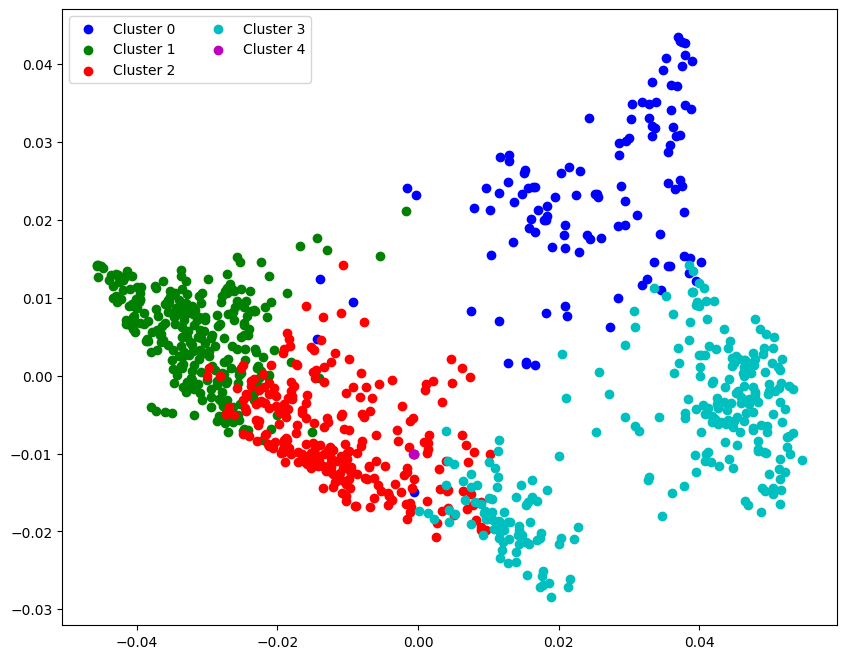

In [123]:
plt.figure(figsize=(10,8))
for i in u_cluster_labels:
    plt.scatter(ph_all_we[cluster_labels == i, 0], ph_all_we[cluster_labels == i, 1], label=f'Cluster {i}', c=color_set[i])
plt.legend(fontsize = 10, ncol = 2)
plt.show()

Although the clustering that PHATE uses is different from the way that K-Means tends to cluster, it appears to be clustering in a reasonable way.

# Cluster Analysis - Topics
To get a better idea of the topics which these clusters correspond to, we will enrich these clusters with the topics from the article sources.